Epoch 1/1000


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4687 - loss: 0.6921 - val_accuracy: 0.2077 - val_loss: 0.7088
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5043 - loss: 0.6843 - val_accuracy: 0.2077 - val_loss: 0.7184
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5017 - loss: 0.6773 - val_accuracy: 0.2132 - val_loss: 0.7212
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5066 - loss: 0.6700 - val_accuracy: 0.2636 - val_loss: 0.7187
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5437 - loss: 0.6612 - val_accuracy: 0.3670 - val_loss: 0.7128
Epoch 6/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6053 - loss: 0.6497 - val_accuracy: 0.4538 - val_loss: 0.7025
Epoch 7/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6647 - loss: 0.6380 - val_accuracy: 0.5529 - val_loss: 0.6838
Epoch 8/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7179 - loss: 0.6208 - val_accuracy: 0.6072 - val_l

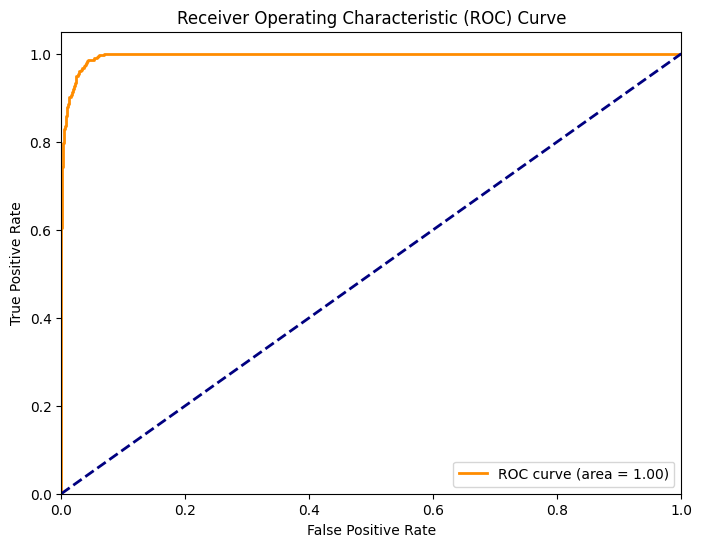

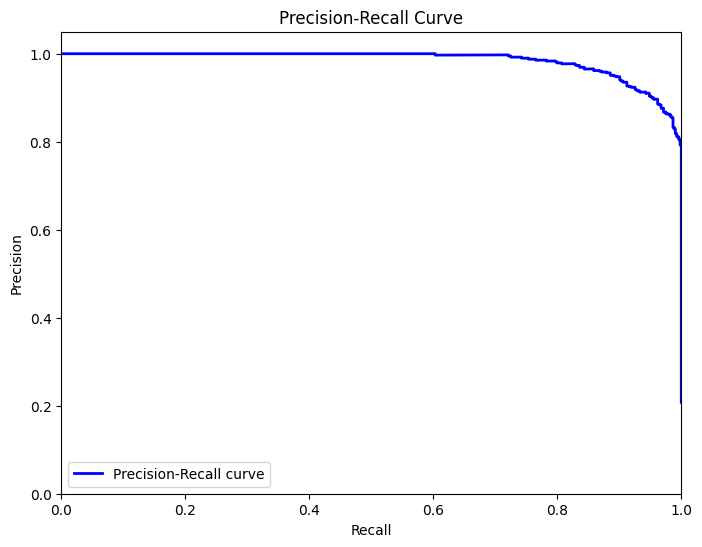

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1999
           1       0.84      0.99      0.91       524

    accuracy                           0.96      2523
   macro avg       0.92      0.97      0.94      2523
weighted avg       0.96      0.96      0.96      2523



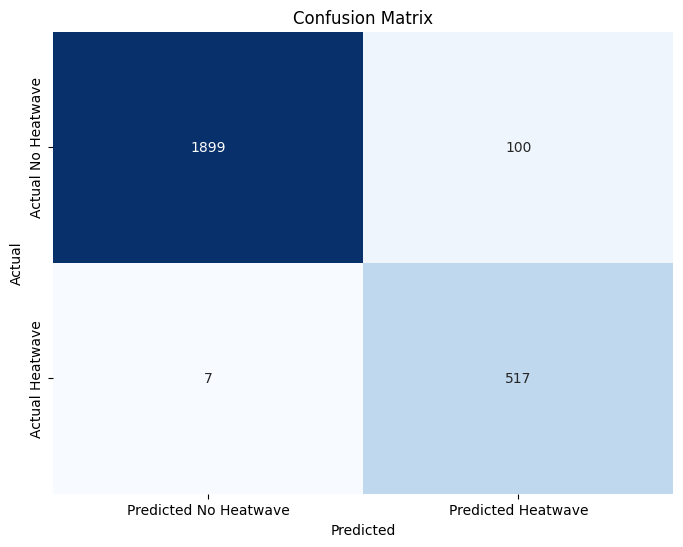

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, f1_score
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_scaled, y, df.index, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000, 
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping])

# Function to predict heatwave for a given date based on historical data and model prediction
def predict_heatwave(input_date):
    selected_data = df[df['time'] == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        return "Historical Data", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid'], selected_data['Heatwave']
    else:
        print(f"No data found for {input_date}. Using LSTM prediction.")
        historical_avg_tavg = df['tavg'].mean()
        historical_avg_tmin = df['tmin'].mean()
        historical_avg_tmax = df['tmax'].mean()
        historical_avg_humid = df['humid'].mean()
        
        # Prepare features for prediction
        future_date = pd.DataFrame({'time': [input_date]})
        future_date['time'] = pd.to_datetime(future_date['time'], format='%Y-%m-%d')
        future_date['day_of_year'] = future_date['time'].dt.dayofyear
        future_date['tavg'] = historical_avg_tavg
        future_date['tmin'] = historical_avg_tmin
        future_date['tmax'] = historical_avg_tmax
        future_date['humid'] = historical_avg_humid
        
        # Scale features
        future_features = future_date[features].values
        future_features_scaled = scaler.transform(future_features)
        
        # Reshape input data for LSTM (samples, time steps, features)
        future_features_reshaped = future_features_scaled.reshape((future_features_scaled.shape[0], 1, future_features_scaled.shape[1]))
        
        # Predict using LSTM model
        prediction_prob = model.predict(future_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)[0][0]
        
        return "LSTM Prediction", historical_avg_tavg, historical_avg_tmin, historical_avg_tmax, historical_avg_humid, prediction

# Continuous user interaction to predict heatwaves
while True:
    user_input = input("Enter a date (YYYY-MM-DD) to predict heatwave (type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    
    try:
        input_date = datetime.strptime(user_input, "%Y-%m-%d").date()
        prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(input_date)
        
        if prediction_type == "Historical Data":
            print(f"Prediction for {input_date}: Based on historical data")
            print(f"Average Temperature: {avg_tavg:.2f} °C")
            print(f"Min Temperature: {avg_tmin:.2f} °C")
            print(f"Max Temperature: {avg_tmax:.2f} °C")
            print(f"Humidity: {avg_humid:.2f} %")
            if prediction == 1:
                print("Heatwave: Yes")
            else:
                print("Heatwave: No")
        else:
            print(f"Prediction for {input_date}: Based on LSTM prediction")
            print(f"Average Temperature: {avg_tavg:.2f} °C")
            print(f"Min Temperature: {avg_tmin:.2f} °C")
            print(f"Max Temperature: {avg_tmax:.2f} °C")
            print(f"Humidity: {avg_humid:.2f} %")
            if prediction == 1:
                print("Predicted Heatwave: Yes")
            else:
                print("Predicted Heatwave: No")

    except ValueError:
        print("Invalid date format. Please enter date in YYYY-MM-DD format.")

# Compute ROC curve and ROC area for each class
y_test_pred_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute precision-recall curve and area the curve
precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# Print classification report
y_test_pred = (y_test_pred_prob > 0.5).astype(int)
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
            xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
            yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [4]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from imblearn.over_sampling import SMOTE
import seaborn as sns

# Load and preprocess data
df = pd.read_csv('hu.csv')

# Convert 'time' column to datetime with the correct format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')

# Sort data by time
df = df.sort_values(by='time')

# Define thresholds for heatwave classification
threshold_temp = 33  # Threshold for high temperature for a heatwave
threshold_humid = 60  # Threshold for high humidity for a heatwave

# Define function to classify heatwave based on temperature and humidity
def classify_heatwave(row):
    if row['tmax'] >= threshold_temp and row['humid'] >= threshold_humid:
        return 1  # Heatwave due to high temperature and high humidity
    else:
        return 0  # Not a heatwave

# Apply classification function to create 'Heatwave' column
df['Heatwave'] = df.apply(classify_heatwave, axis=1)

# Handle missing values by filling with the mean of the respective columns
df.fillna(df.mean(), inplace=True)

# Prepare data for LSTM model
features = ['tavg', 'tmin', 'tmax', 'humid']  # Include 'humid' in features
X = df[features].values
y = df['Heatwave'].values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets and get the indices
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Reshape input data for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.reshape(X_train.shape[0], X_train.shape[2]), y_train)

# Reshape resampled data for LSTM
X_train_resampled = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))

# Adjust class weights to handle imbalanced classes more drastically
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
history = model.fit(X_train_resampled, y_train_resampled, epochs=1000, batch_size=1000,
                    validation_data=(X_test, y_test), class_weight=class_weights_dict,
                    callbacks=[early_stopping], verbose=0)

# Function to predict heatwave for a given date based on historical data and model prediction
def predict_heatwave(input_date):
    selected_data = df[df['time'] == input_date]
    if not selected_data.empty:
        selected_data = selected_data.iloc[0]
        return "Historical Data", selected_data['tavg'], selected_data['tmin'], selected_data['tmax'], selected_data['humid'], selected_data['Heatwave']
    else:
        print(f"No data found for {input_date}. Using LSTM prediction.")
        historical_avg_tavg = df['tavg'].mean()
        historical_avg_tmin = df['tmin'].mean()
        historical_avg_tmax = df['tmax'].mean()
        historical_avg_humid = df['humid'].mean()

        # Prepare features for prediction
        future_date = pd.DataFrame({'time': [input_date]})
        future_date['time'] = pd.to_datetime(future_date['time'], format='%Y-%m-%d')
        future_date['day_of_year'] = future_date['time'].dt.dayofyear
        future_date['tavg'] = historical_avg_tavg
        future_date['tmin'] = historical_avg_tmin
        future_date['tmax'] = historical_avg_tmax
        future_date['humid'] = historical_avg_humid

        # Scale features
        future_features = future_date[features].values
        future_features_scaled = scaler.transform(future_features)

        # Reshape input data for LSTM (samples, time steps, features)
        future_features_reshaped = future_features_scaled.reshape((future_features_scaled.shape[0], 1, future_features_scaled.shape[1]))

        # Predict using LSTM model
        prediction_prob = model.predict(future_features_reshaped)
        prediction = (prediction_prob > 0.5).astype(int)[0][0]

        return "LSTM Prediction", historical_avg_tavg, historical_avg_tmin, historical_avg_tmax, historical_avg_humid, prediction

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    st.pyplot()

# Function to plot Precision-Recall curve
def plot_precision_recall_curve(y_true, y_pred_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    st.pyplot()

# Function to display confusion matrix
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=['Predicted No Heatwave', 'Predicted Heatwave'],
                yticklabels=['Actual No Heatwave', 'Actual Heatwave'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    st.pyplot()

# Streamlit app
def main():
    st.title('Heatwave Prediction App')
    st.sidebar.title('User Input')

    # User input for date
    input_date = st.sidebar.date_input("Enter a date to predict heatwave", datetime.today())

    # Predict heatwave
    prediction_type, avg_tavg, avg_tmin, avg_tmax, avg_humid, prediction = predict_heatwave(input_date)

    # Display prediction results
    st.subheader(f"Prediction for {input_date}:")
    if prediction_type == "Historical Data":
        st.write("Based on historical data")
    else:
        st.write("Based on LSTM prediction")

    st.write(f"Average Temperature: {avg_tavg:.2f} °C")
    st.write(f"Min Temperature: {avg_tmin:.2f} °C")
    st.write(f"Max Temperature: {avg_tmax:.2f} °C")
    st.write(f"Humidity: {avg_humid:.2f} %")
    if prediction == 1:
        st.write("Heatwave: Yes")
    else:
        st.write("Heatwave: No")

    # Compute ROC curve and Precision-Recall curve
    y_test_pred_prob = model.predict(X_test)
    y_test_pred = (y_test_pred_prob > 0.5).astype(int)
    plot_roc_curve(y_test, y_test_pred_prob)
    plot_precision_recall_curve(y_test, y_test_pred_prob)
    display_confusion_matrix(y_test, y_test_pred)

if __name__ == '__main__':
    main()


C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-17 11:48:10.901 
  command:

    streamlit run C:\Users\subbu\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]


No data found for 2024-07-17. Using LSTM prediction.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>